In [2]:
import pandas as pd
import os
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
data = pd.read_csv('cleaned_football_data.csv')
data

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgA,PSCH,PSCD,PSCA,Season,League,LBH,LBD,LBA,HomeWin
0,E0,09/08/2019,Liverpool,Norwich,4,1,H,4.0,0.0,H,...,19.830000,1.14,10.43,19.63,2019,Premier League,2.953658,4.099487,5.155421,1
1,E0,10/08/2019,West Ham,Man City,0,5,A,0.0,1.0,A,...,1.250000,11.11,6.68,1.27,2019,Premier League,2.953658,4.099487,5.155421,0
2,E0,10/08/2019,Bournemouth,Sheffield United,1,1,D,0.0,0.0,D,...,3.830000,1.98,3.67,4.06,2019,Premier League,2.953658,4.099487,5.155421,0
3,E0,10/08/2019,Burnley,Southampton,3,0,H,0.0,0.0,D,...,2.780000,2.71,3.19,2.90,2019,Premier League,2.953658,4.099487,5.155421,1
4,E0,10/08/2019,Crystal Palace,Everton,0,0,D,0.0,0.0,D,...,2.400000,3.37,3.45,2.27,2019,Premier League,2.953658,4.099487,5.155421,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6075,I1,20/05/18,Milan,Fiorentina,5,1,H,2.0,1.0,H,...,4.277143,1.66,4.31,5.23,2017,Serie A,1.800000,3.800000,4.000000,1
6076,I1,20/05/18,Napoli,Crotone,2,1,H,2.0,0.0,H,...,5.790000,1.41,5.55,7.13,2017,Serie A,1.440000,4.600000,6.500000,1
6077,I1,20/05/18,Sassuolo,Roma,0,1,A,0.0,1.0,A,...,1.850000,4.84,3.85,1.78,2017,Serie A,3.800000,3.800000,1.850000,0
6078,I1,20/05/18,Spal,Sampdoria,3,1,H,1.0,0.0,H,...,5.512857,1.85,3.78,4.56,2017,Serie A,1.610000,4.000000,5.200000,1


# Hypothesis Testing 2: Do High-Scoring Matches Have a Higher Probability of Ending in a Draw?

### Hypotheses:
We are testing if **high-scoring matches** (total goals ≥ threshold) are more likely to end in a **draw** compared to **low-scoring matches** (total goals < threshold).

- **Null Hypothesis (H₀)**: High-scoring matches have the same or a lower probability of ending in a draw compared to low-scoring matches.  

  $ H_0: p_{high} - p_{low} \leq 0 $

- **Alternative Hypothesis (H₁)**: High-scoring matches have a **higher probability** of ending in a draw compared to low-scoring matches.  

  $ H_1: p_{high} - p_{low} > 0 $

This is a **right-tailed test**, focusing on whether the probability of a draw is **significantly greater** for high-scoring matches.

---

### Test Setup:

- **Difference**: We calculate the difference between the proportions of draws in high- and low-scoring matches:

  $ \text{Difference} = p_{high} - p_{low} $

- **Region of Practical Equivalence (ROPE)**:  
  We define a **ROPE** to assess if the difference falls within a range that would be considered practically equivalent:  
  **ROPE**: (-0.05, 0.05), meaning differences smaller than 5 percentage points are considered negligible.

---

### Decision Criteria:

- **Reject H₀** if the **difference** is significantly greater than **0.05** (i.e., high-scoring matches are more likely to end in a draw).
- **Fail to Reject H₀** if the **difference** falls within the **ROPE** (-0.05, 0.05), indicating no meaningful difference.

In [9]:
data['TotalGoals'] = data['FTHG'] + data['FTAG']
# Calculate basic summary statistics for TotalGoals
total_goals_summary = data['TotalGoals'].describe()

# Show the summary statistics
total_goals_summary

count    6080.000000
mean        2.819243
std         1.669144
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: TotalGoals, dtype: float64

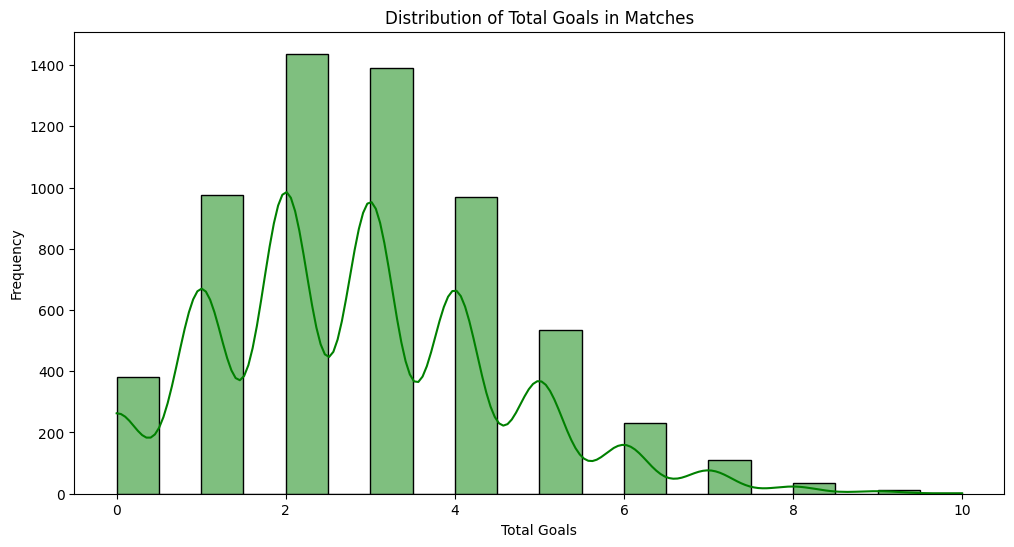

In [10]:
# Visualize the distribution of total goals in matches
plt.figure(figsize=(12, 6))
sns.histplot(data['TotalGoals'], kde=True, bins=20, color='green')
plt.title('Distribution of Total Goals in Matches')
plt.xlabel('Total Goals')
plt.ylabel('Frequency')
plt.show()

### Exploratory Data Analysis (EDA) for Total Goals:

- **Distribution**: The distribution of total goals across matches shows a peak around 2-3 goals, with a tail extending towards higher values (up to 10 total goals).
- **Summary Statistics**:
  - The average total goals per match is **2.82**.
  - The median (50th percentile) is **3**, suggesting that a large number of matches have around 3 goals.
  - The range of total goals is from **0** to **10**, indicating a few high-scoring outlier matches.

### Suggested Threshold:
Based on the distribution, it might make sense to set the **threshold for high-scoring matches** at **3 goals**. Matches with a total of **3 or more goals** can be classified as high-scoring, while those with fewer than 3 goals can be classified as low-scoring.

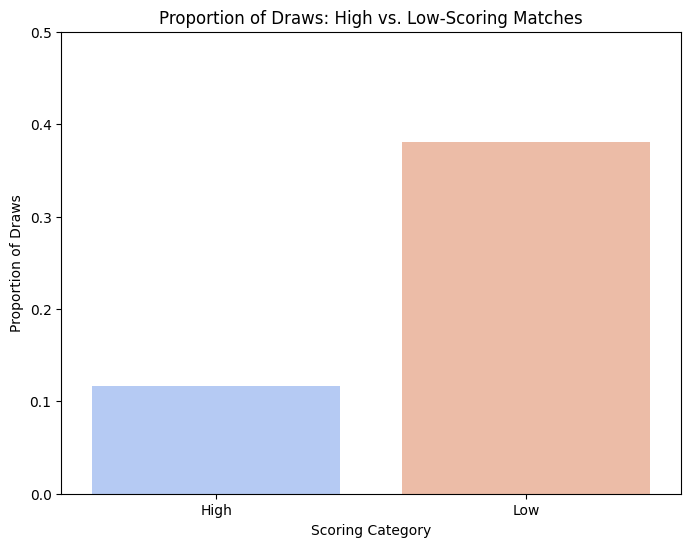

In [11]:
# Create a new column for scoring category based on the threshold
data['ScoringCategory'] = data['TotalGoals'].apply(lambda x: 'High' if x >= 3 else 'Low')

# Calculate the proportion of draws in each scoring category
draw_proportions = data.groupby('ScoringCategory')['FTR'].apply(
    lambda x: (x == 'D').mean()
).reset_index(name='DrawProportion')

# Visualize the proportion of draws in high vs. low-scoring matches
plt.figure(figsize=(8, 6))
sns.barplot(data=draw_proportions, x='ScoringCategory', y='DrawProportion', palette='coolwarm')
plt.title('Proportion of Draws: High vs. Low-Scoring Matches')
plt.xlabel('Scoring Category')
plt.ylabel('Proportion of Draws')
plt.ylim(0, 0.5)
plt.show()

In [12]:
# Display the calculated proportions
draw_proportions

,ScoringCategory,DrawProportion
0,High,0.116895
1,Low,0.381038


### Results:
- The proportion of draws in **high-scoring matches** is approximately **11.7%**.
- The proportion of draws in **low-scoring matches** is significantly higher, at around **38.1%**.

This suggests that low-scoring matches are much more likely to result in a draw than high-scoring matches. let's test that:

---

We can now move forward with the hypothesis testing:
- **Null Hypothesis ($H_0$)**: High-scoring matches have the same or a lower probability of resulting in a draw compared to low-scoring matches.
- **Alternative Hypothesis ($H_1$)**: High-scoring matches have a higher probability of resulting in a draw compared to low-scoring matches

In [13]:
# Count the number of draws and total matches in each scoring category
draw_counts = data.groupby('ScoringCategory')['FTR'].apply(lambda x: (x == 'D').sum())
total_counts = data.groupby('ScoringCategory')['FTR'].count()

# Extract counts for high and low-scoring matches
draw_high, draw_low = draw_counts['High'], draw_counts['Low']
total_high, total_low = total_counts['High'], total_counts['Low']

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_high1, p_low1]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_high2, p_low2]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


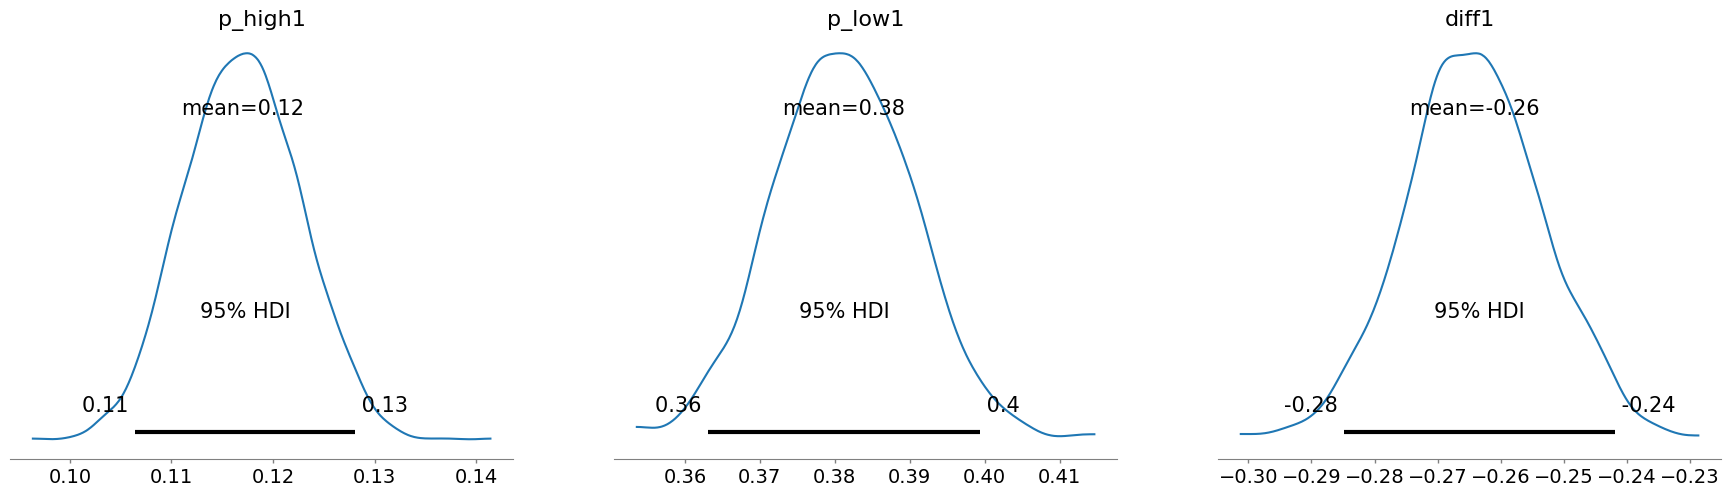

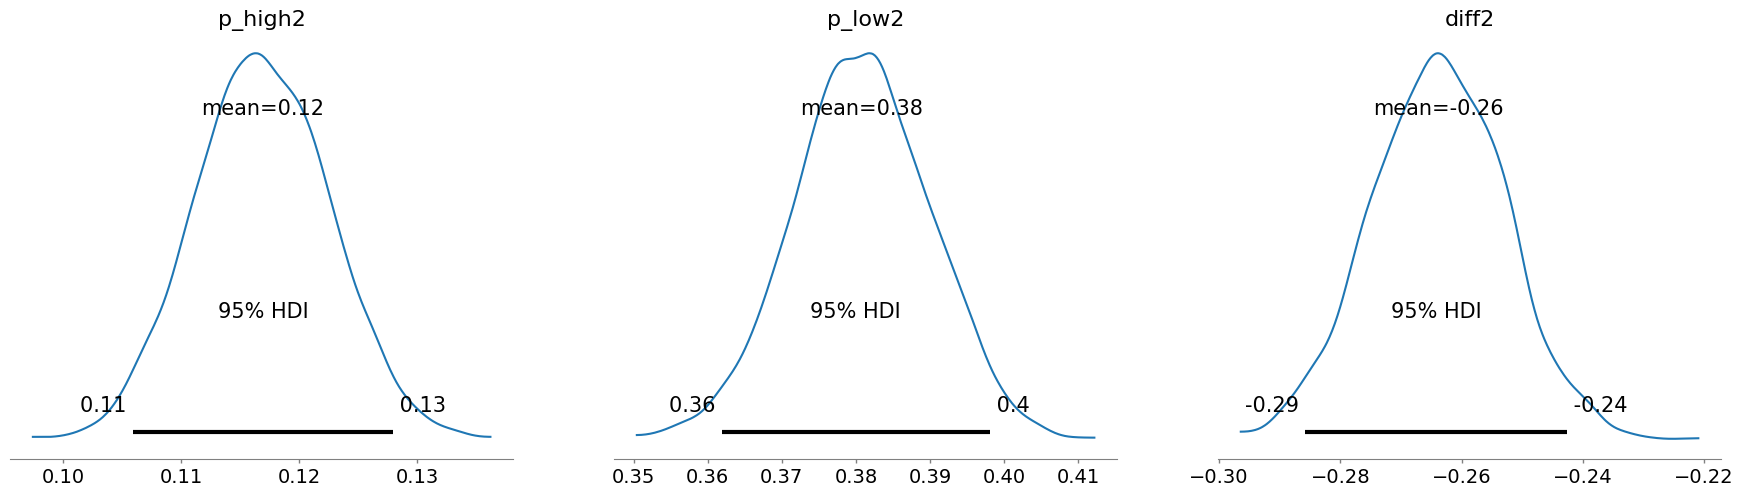

In [46]:
# Define the first Bayesian model with the first set of priors
with pm.Model() as model1:
    # Priors for draw probabilities (Beta prior: uniform)
    p_high1 = pm.Beta('p_high1', alpha=1, beta=1)
    p_low1 = pm.Beta('p_low1', alpha=1, beta=1)

    # Likelihood for the observed draws
    draws_high1 = pm.Binomial('draws_high1', n=total_high, p=p_high1, observed=draw_high)
    draws_low1 = pm.Binomial('draws_low1', n=total_low, p=p_low1, observed=draw_low)
    
    # Difference between high and low draw probabilities
    diff1 = pm.Deterministic('diff1',p_high1 - p_low1)
    
    # Sampling from the posterior, directly returning InferenceData
    trace1 = pm.sample(2000, cores=2, return_inferencedata=True)

# Define the second Bayesian model with the second set of priors
with pm.Model() as model2:
    # Priors for draw probabilities (Beta prior: informative)
    p_high2 = pm.Beta('p_high2', alpha=1, beta=8)
    p_low2 = pm.Beta('p_low2', alpha=2, beta=5)

    # Likelihood for the observed draws
    draws_high2 = pm.Binomial('draws_high2', n=total_high, p=p_high2, observed=draw_high)
    draws_low2 = pm.Binomial('draws_low2', n=total_low, p=p_low2, observed=draw_low)
    
    # Difference between high and low draw probabilities
    diff2 = pm.Deterministic('diff2', p_high2 - p_low2)
    
    # Sampling from the posterior, directly returning InferenceData
    trace2 = pm.sample(2000, cores=2, return_inferencedata=True)

# Summarize and visualize the posterior distributions for both models
az.plot_posterior(trace1, var_names=['p_high1', 'p_low1', 'diff1'], hdi_prob=0.95)
plt.show()

az.plot_posterior(trace2, var_names=['p_high2', 'p_low2', 'diff2'], hdi_prob=0.95)
plt.show()

In [47]:
# Extract summary statistics for the posterior
posterior_summary_1 = az.summary(trace1, var_names=['p_high1', 'p_low1', 'diff1'])
posterior_summary_2 = az.summary(trace2, var_names=['p_high2', 'p_low2', 'diff2'])
posterior_summary_1

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_high1,0.117,0.006,0.106,0.127,0.0,0.0,4186.0,3127.0,1.0
p_low1,0.381,0.009,0.363,0.398,0.0,0.0,3874.0,3068.0,1.0
diff1,-0.264,0.011,-0.285,-0.243,0.0,0.0,4091.0,2988.0,1.0


In [48]:
posterior_summary_2

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_high2,0.117,0.006,0.106,0.127,0.0,0.0,4593.0,2675.0,1.0
p_low2,0.381,0.009,0.363,0.398,0.0,0.0,4106.0,2960.0,1.0
diff2,-0.264,0.011,-0.286,-0.244,0.0,0.0,4161.0,2475.0,1.0


To evaluate the **Region of Practical Equivalence (ROPE)**, we will:

1. Define a ROPE for the difference in draw probabilities ($ p_{high} - p_{low} $):
   - Suggested range: $[-0.05, 0.05]$, meaning differences smaller than 5 percentage points are practically negligible.
2. Check the proportion of the posterior distribution of the difference that falls:
   - **Within the ROPE**: Indicates no meaningful difference.
   - **Below the ROPE**: Suggests $ p_{high} $ is significantly smaller than $ p_{low} $.
   - **Above the ROPE**: Suggests $ p_{high} $ is significantly greater than $ p_{low} $.

In [49]:
# Define the ROPE range
rope_min, rope_max = -0.05, 0.05

# Extract the posterior samples for the difference
diff_posterior1 = trace1.posterior['diff1'].values.flatten()

# Compute the proportions of the posterior within, below, and above the ROPE
within_rope1 = np.mean((diff_posterior1 >= rope_min) & (diff_posterior1 <= rope_max))
below_rope1 = np.mean(diff_posterior1 < rope_min)
above_rope1 = np.mean(diff_posterior1 > rope_max)

# Display the results
rope_results1 = {
    "Proportion within ROPE": within_rope1,
    "Proportion below ROPE": below_rope1,
    "Proportion above ROPE": above_rope1
}
rope_results1

{'Proportion within ROPE': 0.0,
 'Proportion below ROPE': 1.0,
 'Proportion above ROPE': 0.0}

In [50]:
# Extract the posterior samples for the difference
diff_posterior2 = trace2.posterior['diff2'].values.flatten()

# Compute the proportions of the posterior within, below, and above the ROPE
within_rope2 = np.mean((diff_posterior2 >= rope_min) & (diff_posterior2 <= rope_max))
below_rope2 = np.mean(diff_posterior2 < rope_min)
above_rope2 = np.mean(diff_posterior2 > rope_max)

# Display the results
rope_results2 = {
    "Proportion within ROPE": within_rope2,
    "Proportion below ROPE": below_rope2,
    "Proportion above ROPE": above_rope2
}
rope_results2

{'Proportion within ROPE': 0.0,
 'Proportion below ROPE': 1.0,
 'Proportion above ROPE': 0.0}

<Figure size 800x600 with 0 Axes>

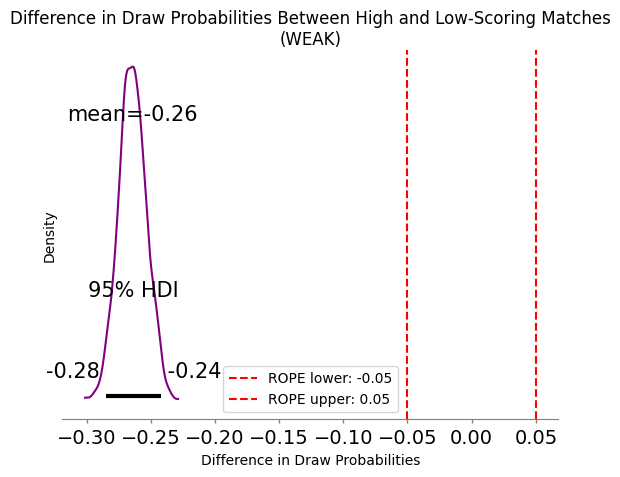

<Figure size 800x600 with 0 Axes>

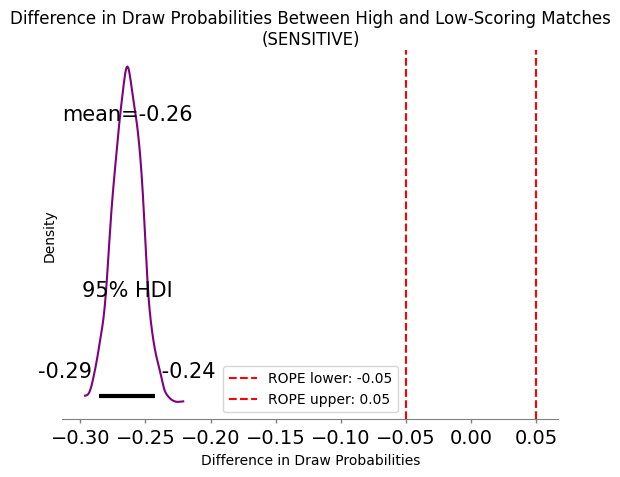

In [51]:
#plot rope1
plt.figure(figsize=(8, 6))
az.plot_posterior(diff_posterior1, hdi_prob=0.95, color='purple')
plt.axvline(rope_min, color='red', linestyle='--', label=f'ROPE lower: {rope_min}')
plt.axvline(rope_max, color='red', linestyle='--', label=f'ROPE upper: {rope_max}')
plt.title('Difference in Draw Probabilities Between High and Low-Scoring Matches (WEAK)')
plt.xlabel('Difference in Draw Probabilities')
plt.ylabel('Density')
plt.legend()
plt.show()
#plot rope2
plt.figure(figsize=(8, 6))
az.plot_posterior(diff_posterior2, hdi_prob=0.95, color='purple')
plt.axvline(rope_min, color='red', linestyle='--', label=f'ROPE lower: {rope_min}')
plt.axvline(rope_max, color='red', linestyle='--', label=f'ROPE upper: {rope_max}')
plt.title('Difference in Draw Probabilities Between High and Low-Scoring Matches (SENSITIVE)')
plt.xlabel('Difference in Draw Probabilities')
plt.ylabel('Density')
plt.legend()
plt.show()

The Bayesian analysis indicates that the **proportion of the posterior below the ROPE is 1.0**, meaning there is strong evidence that **low-scoring matches have a significantly higher probability of ending in a draw than high-scoring matches**.

### Frequentist Comparison:

To compare results, we will:
1. Perform a **two-proportion z-test** to compare the draw probabilities for high- and low-scoring matches.
2. Compute the p-value to determine if the difference is statistically significant.

In [54]:
from statsmodels.stats.proportion import proportions_ztest
# Counts of draws and total matches for high and low-scoring matches
counts = np.array([draw_high, draw_low])
nobs = np.array([total_high, total_low])
# Perform the two-proportion z-test
z_stat, p_value = proportions_ztest(count=counts, nobs=nobs, alternative='larger')

# Display the z-statistic and p-value
frequentist_results = {
    "Z-Statistic": z_stat,
    "P-Value": p_value
}
frequentist_results

{'Z-Statistic': -24.092242796116704, 'P-Value': 1.0}

### Frequentist Test Results:

- **Z-Statistic**: -24.09  
  A very low Z-statistic suggests that the observed difference in draw proportions between high- and low-scoring matches is far from what would be expected under the alternative hypothesis.

- **P-Value**: 1
  This  p-value indicates overwhelming evidence against the alternative hypothesis. The difference in draw proportions is statistically significant.

---

### Conclusion:

- **Bayesian Analysis**: The posterior probability of the difference being below the ROPE was 1.0, strongly supporting that low-scoring matches have a higher draw probability.
- **Frequentist Analysis**: The p-value confirms this result with high statistical significance.

Both methods are in agreement: **low-scoring matches are significantly more likely to end in a draw compared to high-scoring matches.**
